# Setup

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score, recall_score,mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV


In [22]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(f"/Equipo_4/Absenteeism_at_work")

<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1728862130699, experiment_id='9', last_update_time=1728862130699, lifecycle_stage='active', name='/Equipo_4/Absenteeism_at_work', tags={}>

In [23]:
class DataHandler:
    @staticmethod
    def load_data(filepath, sep=";"):
        print("1.- Loading and exploring the data")
        data = pd.read_csv(filepath, sep=sep)
        return data

    @staticmethod
    def prepared_data(data):
        print("2.- Prepared the data")
        print(data.describe())
        print("Número de filas en el dataset:", data.shape[0])
        print("Número de columnas en el dataset:", data.shape[1])
        print("\nPrimeras filas del conjunto de datos:")
        print(data.head())

        # Revisar valores nulos
        print("\nRevisar valores nulos:")
        missing_data_summary = data.isnull().sum()
        print(missing_data_summary)

        # Eliminar filas con valores nulos
        df_cleaned = data.dropna()
        print("\nValores nulos después de limpieza:")
        print(df_cleaned.isnull().sum())

        # Resumen del DataFrame limpio
        print("\nResumen del DataFrame limpio:")
        print(df_cleaned.info())

        return df_cleaned

    @staticmethod
    def plot_histograms(data):
        data.hist(bins=15, figsize=(15, 10))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data):
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.show()

    @staticmethod
    def plot_feature_relationships(data, target):
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=data)
        plt.xticks(rotation=90)
        plt.title(f'Diagrama de caja de todas las variables numéricas con respecto a {target}')
        plt.show()
    
    @staticmethod
    def versioned_data(data):
        print("3.- Versioned the data")
        data.to_csv('absenteeism_data.csv', index=False)
        print("Versión de datos: v1")
        print("Hash del archivo:", hash(tuple(data.values.tobytes())))

In [24]:
class Preprocessor:
    def scale_features(self, data, numeric_columns):
        scaler = StandardScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
        return data

    def encode_categorical_columns(self, data, categorical_columns):
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            data[col] = label_encoder.fit_transform(data[col])
        return data

    def apply_pca(self, data, numeric_columns, n_components=2):
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data[numeric_columns])
        data['PCA1'] = pca_result[:, 0]
        data['PCA2'] = pca_result[:, 1]
        return data

    def preprocess_data(self, df, numeric_columns, categorical_columns):
        df = self.scale_features(df, numeric_columns)
        df = self.encode_categorical_columns(df, categorical_columns)
        df = self.apply_pca(df, numeric_columns)
        return df

In [25]:
class ModelTraining:
    def define_models(self):
        return {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
        }
    
    def define_hyperparameters(self):  # Agregar self aquí
        return {
            'Logistic Regression': {
                'classifier__C': [0.01, 0.1, 1, 10],
                'classifier__solver': ['lbfgs', 'liblinear']
            },
            'Random Forest': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [None, 10, 20],
                'classifier__min_samples_split': [2, 5]
            },
            'Gradient Boosting': {
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.05, 0.1],
                'classifier__max_depth': [3, 5]
            },
            'K-Nearest Neighbors': {
                'classifier__n_neighbors': [3, 5, 7],
                'classifier__weights': ['uniform', 'distance']
            }
        }

    
    def split_data(self, data, target, test_size=0.2, random_state=42):
        X = data.drop(target, axis=1)
        y = data[target]
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

    def get_best_model(self, param_grid, model_pipeline, X_train, y_train, model_name):
        grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        return grid_search.best_estimator_

    def evaluate_classification_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        return accuracy, report, cm, y_pred

    def plot_confusion_matrix(self, cm, model_name):
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.ylabel('Etiqueta verdadera')
        plt.xlabel('Etiqueta predicha')
        plt.show()

    def plot_feature_importance(self, model, feature_names, model_name):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 6))
        plt.barh([feature_names[i] for i in sorted_idx], importance[sorted_idx], color="b")
        plt.title(f'Importancia de características - {model_name}')
        plt.show()


In [26]:
class ModelEvaluation:
    def train_and_evaluate_models(self, models, param_grids, X_train, y_train, X_test, y_test):
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")

            # Configuración de MLflow para registrar el experimento
            mlflow.set_tracking_uri("http://localhost:5000")
            mlflow.set_experiment(f"ML_Models_Absenteeism_Equipo4_{model_name}")

            with mlflow.start_run(nested=True) as run:
                # Registrar hiperparámetros en MLflow
                mlflow.log_param("model_name", model_name)

                # Crear pipeline del modelo
                model_pipeline = Pipeline(steps=[('classifier', model)])
                best_model = ModelTraining().get_best_model(param_grids[model_name], model_pipeline, X_train, y_train, model_name)

                # Evaluar el modelo y registrar métricas en MLflow
                accuracy, report, cm, y_pred = ModelTraining().evaluate_classification_model(best_model, X_test, y_test)
                
                # Calcular precisión y recuperación
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

                # Registrar métricas en MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                print(f"{model_name} Accuracy: {accuracy}\n")
                print(f"Classification Report for {model_name}:\n{report}\n")
                ModelTraining().plot_confusion_matrix(cm, model_name)

                # Registrar el modelo en MLflow
                mlflow.sklearn.log_model(best_model, "model")
                print(f"Modelo registrado en MLflow para {model_name}")

                # Validación cruzada
                cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
                mlflow.log_metric("cross_val_accuracy", np.mean(cross_val_scores))
                print(f"{model_name} Cross-Validation Accuracy: {np.mean(cross_val_scores)}\n")

                # Importancia de características para Random Forest y Gradient Boosting
                if model_name in ['Random Forest', 'Gradient Boosting']:
                    ModelTraining().plot_feature_importance(best_model.named_steps['classifier'], X_train.columns, model_name)

    
    def train_and_evaluate_models_with_balancing(self, models, param_grids, X_train, y_train, X_test, y_test):
        # Aplicar sobremuestreo a los datos de entrenamiento
        print("\nAplicando RandomOverSampler para balanceo de clases...")
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        print(f"Nuevas formas de X_train: {X_train_resampled.shape}, y_train: {y_train_resampled.shape}")
        
        for model_name, model in models.items():
            print(f"\nTraining {model_name} con datos balanceados...")

            # Configuración de MLflow para registrar el experimento
            mlflow.set_tracking_uri("http://localhost:5000")
            mlflow.set_experiment(f"ML_Models_Absenteeism_Equipo4_Balanced_{model_name}")

            with mlflow.start_run(nested=True) as run:
                # Registrar hiperparámetros en MLflow
                mlflow.log_param("model_name", model_name)

                # Crear pipeline del modelo
                model_pipeline = Pipeline(steps=[('classifier', model)])
                best_model = ModelTraining().get_best_model(param_grids[model_name], model_pipeline, X_train_resampled, y_train_resampled, model_name)

                # Evaluar el modelo y registrar métricas en MLflow
                accuracy, report, cm, y_pred = ModelTraining().evaluate_classification_model(best_model, X_test, y_test)
                
                # Calcular precisión y recuperación
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

                # Registrar métricas en MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                print(f"{model_name} Accuracy: {accuracy}\n")
                print(f"Classification Report for {model_name}:\n{report}\n")
                ModelTraining().plot_confusion_matrix(cm, model_name)

                # Registrar el modelo en MLflow
                mlflow.sklearn.log_model(best_model, "model")
                print(f"Modelo registrado en MLflow para {model_name}")

                # Validación cruzada
                cross_val_scores = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=StratifiedKFold(n_splits=2), scoring='accuracy')
                mlflow.log_metric("cross_val_accuracy", np.mean(cross_val_scores))
                print(f"{model_name} Cross-Validation Accuracy: {np.mean(cross_val_scores)}\n")

                # Importancia de características para Random Forest y Gradient Boosting
                if model_name in ['Random Forest', 'Gradient Boosting']:
                    ModelTraining().plot_feature_importance(best_model.named_steps['classifier'], X_train.columns, model_name)             



In [27]:
def main(filepath):
    # 1. Cargar y preparar los datos
    data = DataHandler.load_data(filepath)
    df_cleaned = DataHandler.prepared_data(data)
   
    # 2. Exploración y preprocesamiento de datos
    DataHandler.plot_histograms(df_cleaned)
    DataHandler.plot_correlation_matrix(df_cleaned)
    DataHandler.plot_feature_relationships(df_cleaned, 'Absenteeism time in hours')

    # Definir las columnas numéricas y categóricas
    numeric_columns = ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target']
    categorical_columns = ['Month of absence', 'Day of the week', 'Seasons', 'Education', 'Disciplinary failure', 'Social drinker', 'Social smoker']

    # Preprocesamiento de los datos
    preprocessor = Preprocessor()
    df_preprocessed = preprocessor.preprocess_data(df_cleaned, numeric_columns, categorical_columns)


    # 4. Dividir los datos para entrenamiento y evaluación
    model_training = ModelTraining()
    X_train, X_test, y_train, y_test = model_training.split_data(df_preprocessed, 'Absenteeism time in hours')

    models = model_training.define_models()
    param_grids = model_training.define_hyperparameters()

    print("\n### Entrenamiento y Evaluación Inicial ###")
    model_evaluation = ModelEvaluation()
    model_evaluation.train_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test)

    # 5. Aplicar Mejores Prácticas en el Pipeline de Modelado (balanceo de clases y optimización de hiperparámetros)
    print("\n### Aplicación de Mejores Prácticas ###")
    model_evaluation.train_and_evaluate_models_with_balancing(models, param_grids, X_train, y_train, X_test, y_test)


1.- Loading and exploring the data
2.- Prepared the data
               ID  Reason for absence  Month of absence  Day of the week  \
count  740.000000          740.000000        740.000000       740.000000   
mean    18.017568           19.216216          6.324324         3.914865   
std     11.021247            8.433406          3.436287         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%      9.000000           13.000000          3.000000         3.000000   
50%     18.000000           23.000000          6.000000         4.000000   
75%     28.000000           26.000000          9.000000         5.000000   
max     36.000000           28.000000         12.000000         6.000000   

          Seasons  Transportation expense  Distance from Residence to Work  \
count  740.000000              740.000000                       740.000000   
mean     2.544595              221.329730                        29.631081   
std      1.111831       

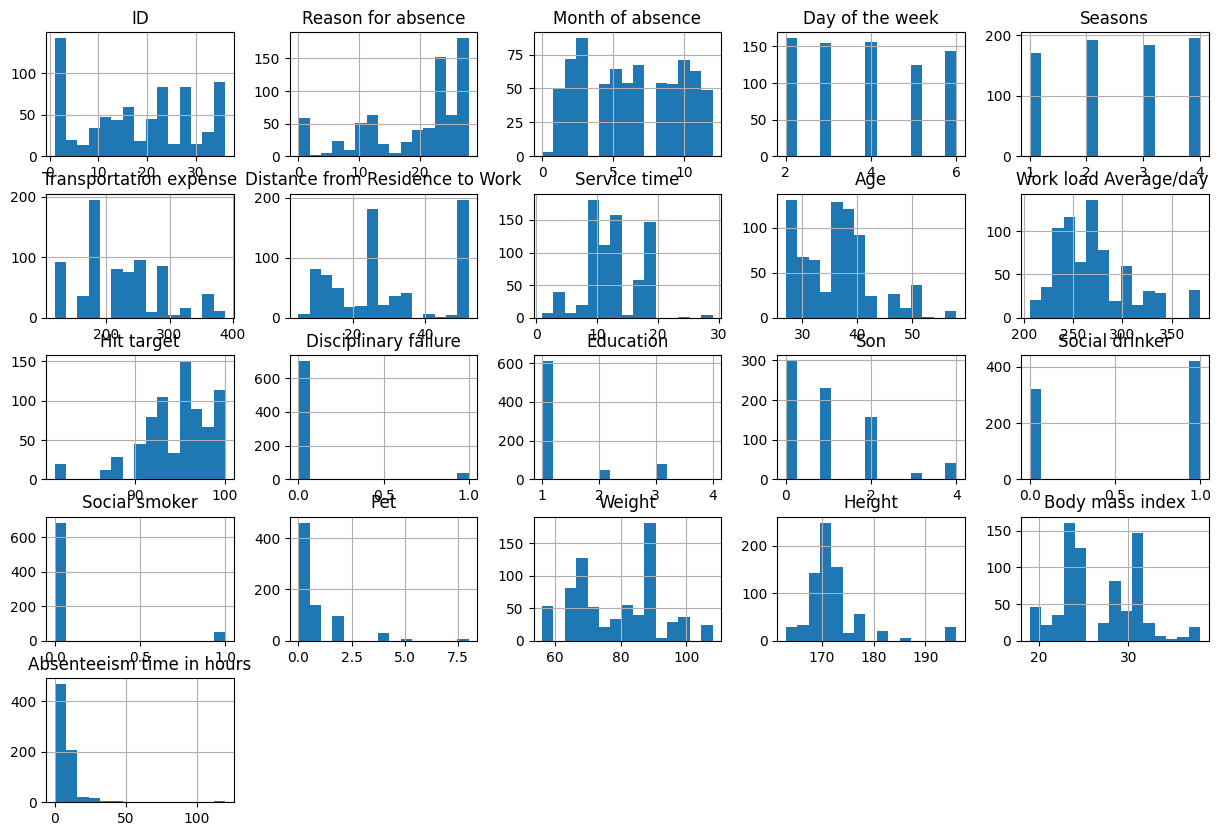

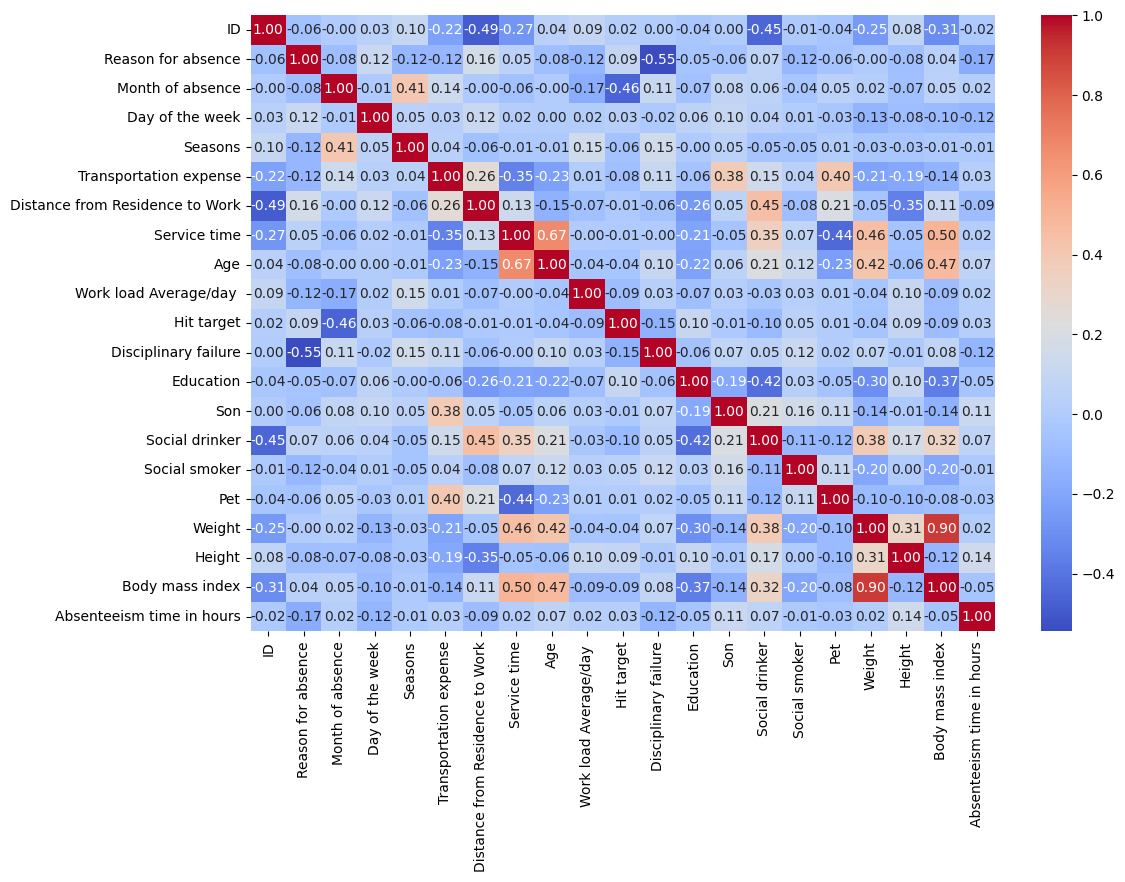

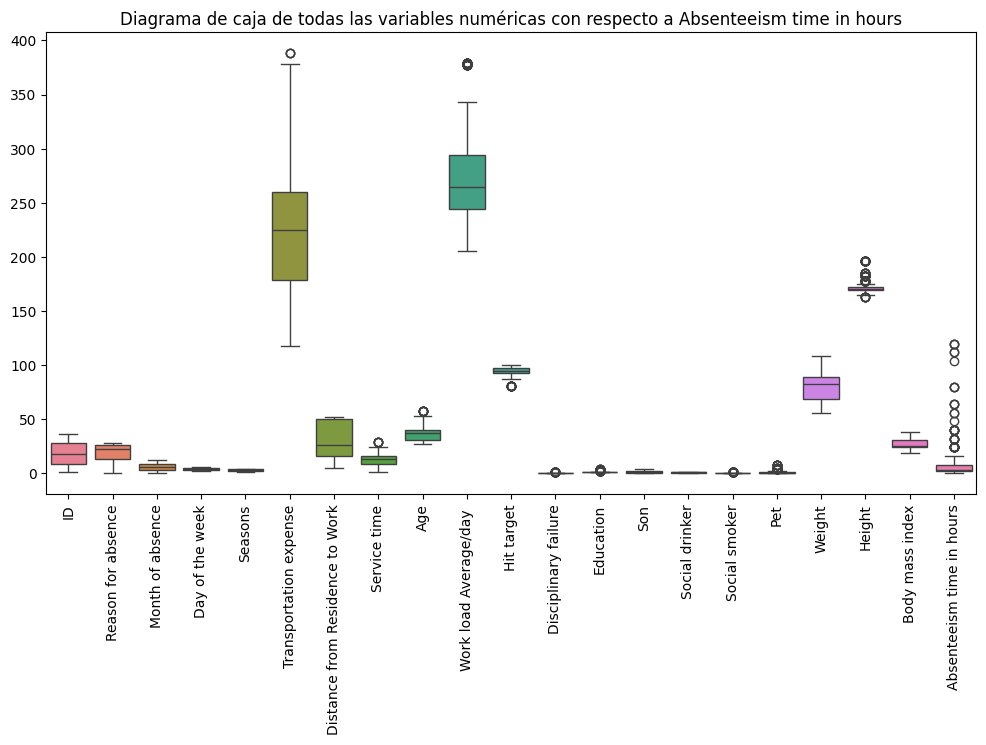


### Entrenamiento y Evaluación Inicial ###

Training Logistic Regression...


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the numb

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Logistic Regression Accuracy: 0.4527027027027027

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.18      0.11      0.13        19
           2       0.48      0.45      0.47        33
           3       0.16      0.16      0.16        19
           4       0.60      0.25      0.35        12
           5       0.00      0.00      0.00         2
           8       0.49      0.81      0.61        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00      0.00         2

    accuracy                           0.45       148
   macro avg       0.22      0.23      0.22       

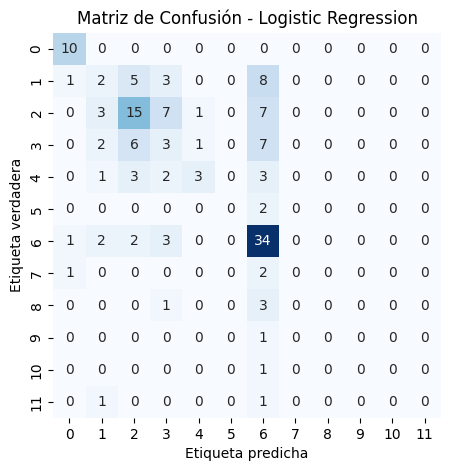

2024/10/19 11:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Logistic Regression


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the numb

Logistic Regression Cross-Validation Accuracy: 0.4375


Training Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Random Forest Accuracy: 0.47297297297297297

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.27      0.21      0.24        19
           2       0.50      0.39      0.44        33
           3       0.37      0.37      0.37        19
           4       0.29      0.33      0.31        12
           5       0.00      0.00      0.00         2
           8       0.51      0.76      0.61        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00      0.00    

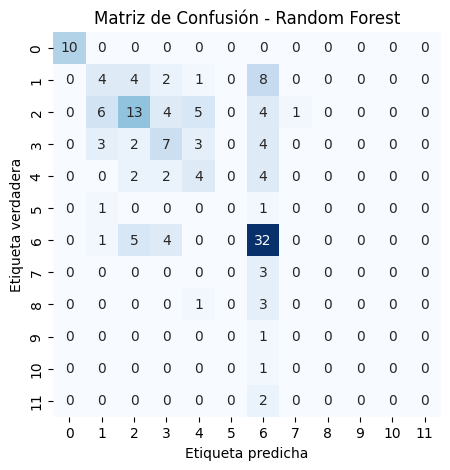

2024/10/19 11:49:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Random Forest


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Random Forest Cross-Validation Accuracy: 0.4898648648648648



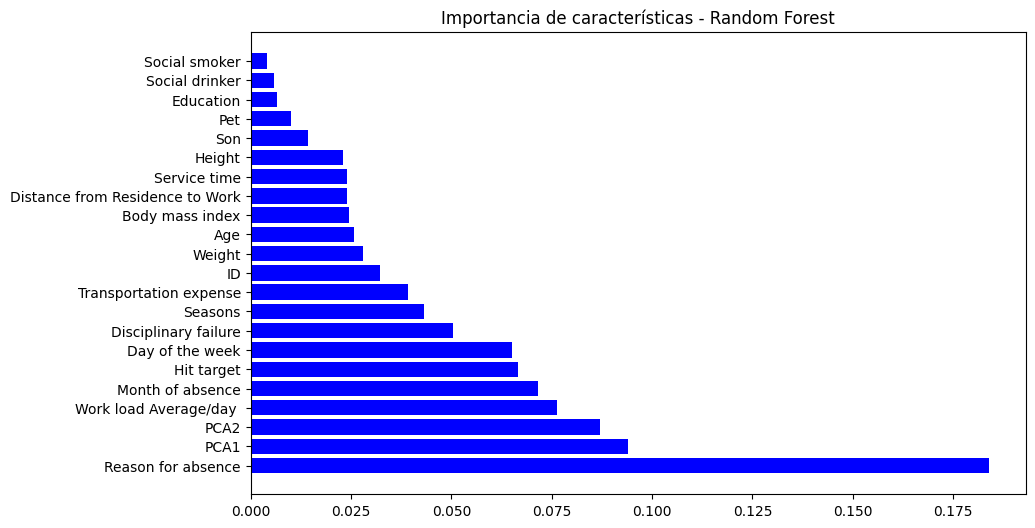

2024/10/19 11:49:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-cat-620 at: http://localhost:5000/#/experiments/11/runs/56c90f36ca7d4dd0b440d6474f25b63f.
2024/10/19 11:49:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/11.
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(



Training Gradient Boosting...
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Gradient Boosting Accuracy: 0.4864864864864865

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.23      0.16      0.19        19
           2       0.53      0.52      0.52        33
           3       0.33      0.37      0.35        19
           4       0.36      0.33      0.35        12
           5       0.00      0.00      0.00         2
           8       0.57      0.74      0.65        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64       0.00      0.00      0.00         0
          80       0.00      0.00    

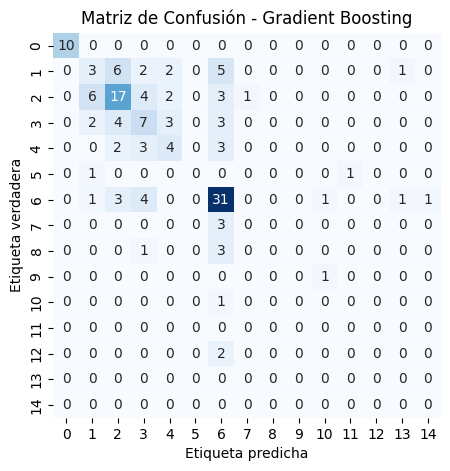

2024/10/19 11:51:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Gradient Boosting


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Gradient Boosting Cross-Validation Accuracy: 0.47297297297297297



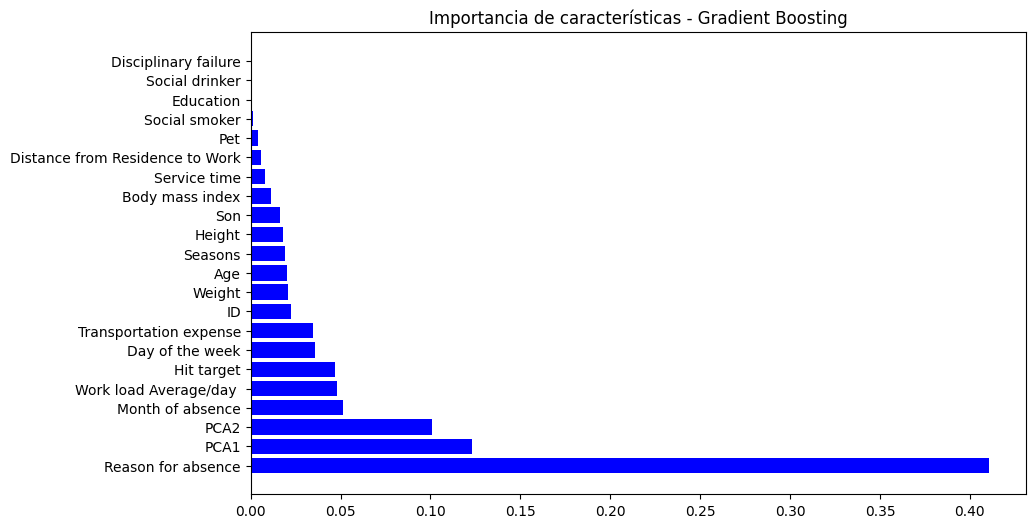

2024/10/19 11:51:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-panda-300 at: http://localhost:5000/#/experiments/12/runs/8545206b1762495f835724081a976186.
2024/10/19 11:51:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/12.
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(



Training K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors Accuracy: 0.42567567567567566

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.14      0.16      0.15        19
           2       0.42      0.39      0.41        33
           3       0.33      0.37      0.35        19
           4       0.29      0.17      0.21        12
           5       0.00      0.00      0.00         2
           8       0.51      0.67      0.58        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          80       0.00      0.00      0.00         2

    accuracy                           0.43       148
   ma

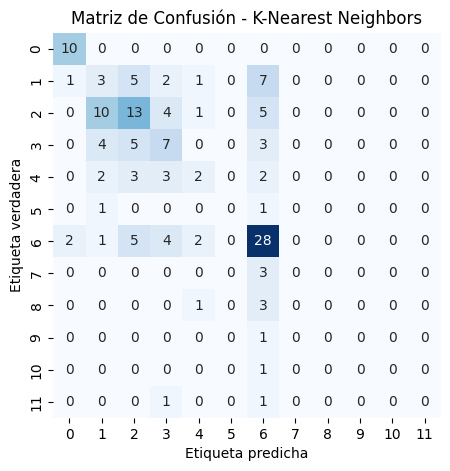

2024/10/19 11:51:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
2024/10/19 11:51:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-turtle-226 at: http://localhost:5000/#/experiments/13/runs/4ab0d5ef41e3483aa5bb8fe90713c6b4.
2024/10/19 11:51:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/13.


Modelo registrado en MLflow para K-Nearest Neighbors
K-Nearest Neighbors Cross-Validation Accuracy: 0.41216216216216217


### Aplicación de Mejores Prácticas ###

Aplicando RandomOverSampler para balanceo de clases...
Nuevas formas de X_train: (3154, 22), y_train: (3154,)

Training Logistic Regression con datos balanceados...


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Logistic Regression Accuracy: 0.2702702702702703

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.29      0.26      0.28        19
           2       0.39      0.21      0.27        33
           3       0.22      0.21      0.22        19
           4       0.24      0.33      0.28        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.42      0.19      0.26        42
          16       0.00      0.00      0.00         3
          24       0.30      0.75      0.43         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         0
          56       0.00      0.00      0.00         

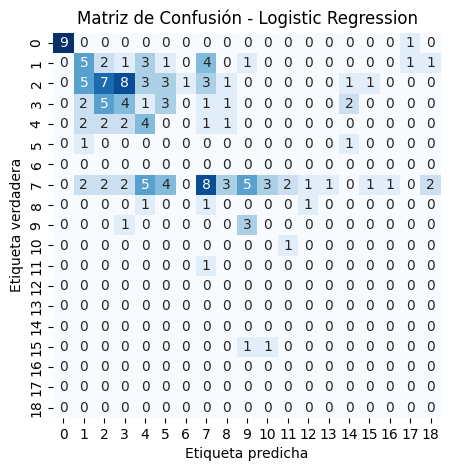

2024/10/19 11:51:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Logistic Regression


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression Cross-Validation Accuracy: 0.7308180088776157


Training Random Forest con datos balanceados...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Random Forest Accuracy: 0.43243243243243246

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.31      0.26      0.29        19
           2       0.45      0.27      0.34        33
           3       0.35      0.37      0.36        19
           4       0.14      0.17      0.15        12
           5       0.00      0.00      0.00         2
           8       0.53      0.74      0.62        42
          16       0.00      0.00      0.00         3
          24       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64 

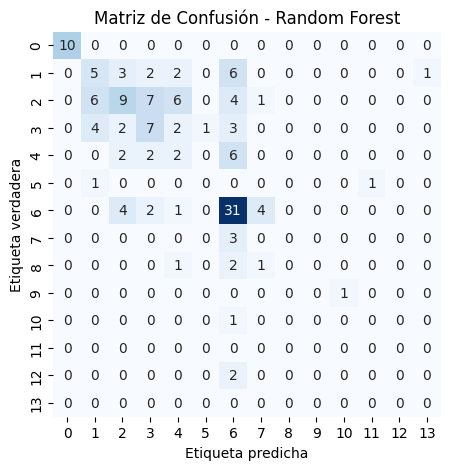

2024/10/19 11:51:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Random Forest
Random Forest Cross-Validation Accuracy: 0.9013950538998098



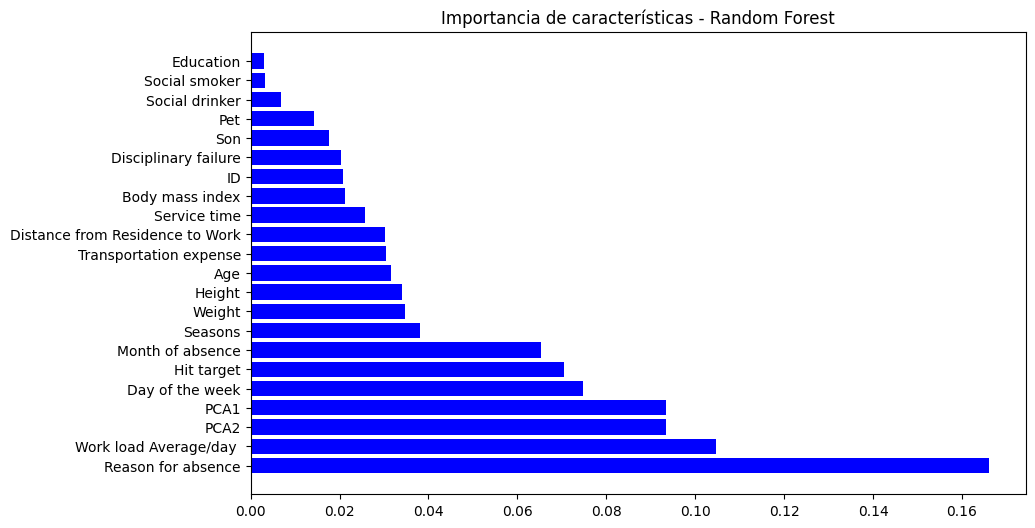

2024/10/19 11:51:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-snail-246 at: http://localhost:5000/#/experiments/19/runs/5d8b54d6acab41bea581eab1e4d06f42.
2024/10/19 11:51:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/19.



Training Gradient Boosting con datos balanceados...
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Gradient Boosting Accuracy: 0.46621621621621623

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.35      0.37      0.36        19
           2       0.43      0.30      0.36        33
           3       0.35      0.42      0.38        19
           4       0.20      0.17      0.18        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.60      0.74      0.66        42
          16       0.00      0.00      0.00         3
          24       1.00      0.25      0.40         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          64  

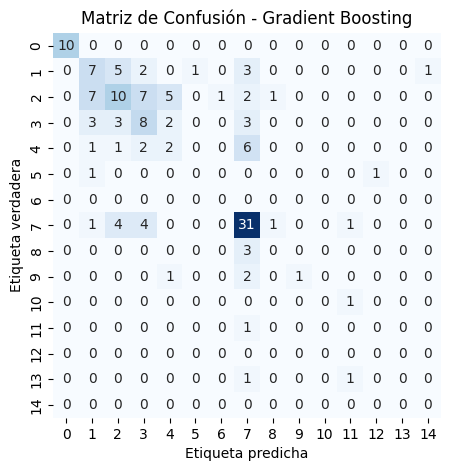

2024/10/19 11:54:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado en MLflow para Gradient Boosting
Gradient Boosting Cross-Validation Accuracy: 0.9112238427393786



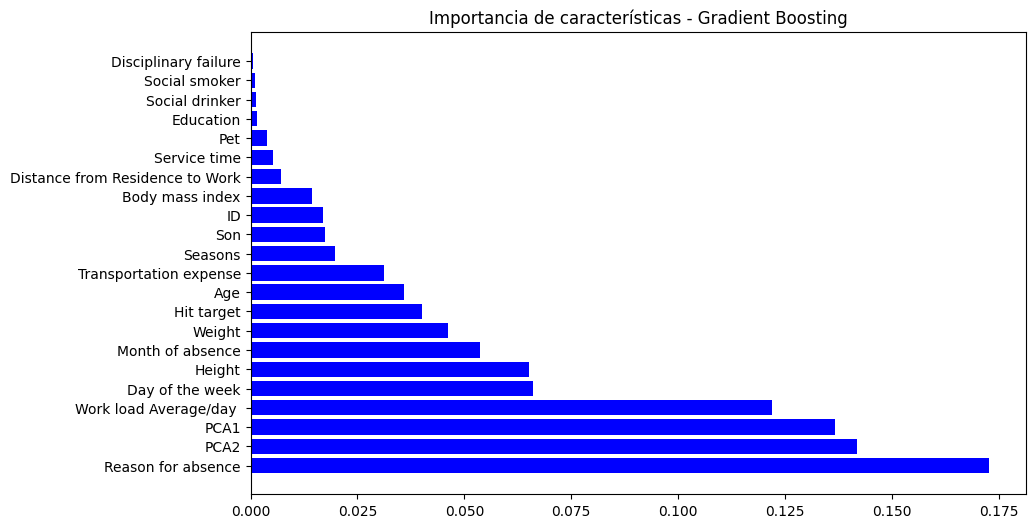

2024/10/19 11:54:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run bemused-auk-218 at: http://localhost:5000/#/experiments/20/runs/b8c0b84e8817481e8d8a0581c0b17c3a.
2024/10/19 11:54:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/20.



Training K-Nearest Neighbors con datos balanceados...
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
K-Nearest Neighbors Accuracy: 0.33783783783783783

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.24      0.26      0.25        19
           2       0.46      0.33      0.39        33
           3       0.25      0.26      0.26        19
           4       0.28      0.42      0.33        12
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.48      0.31      0.38        42
          16       0.00      0.00      0.00         3
          24       0.50      0.25      0.33         4
          32       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          48       0.00      0.00    

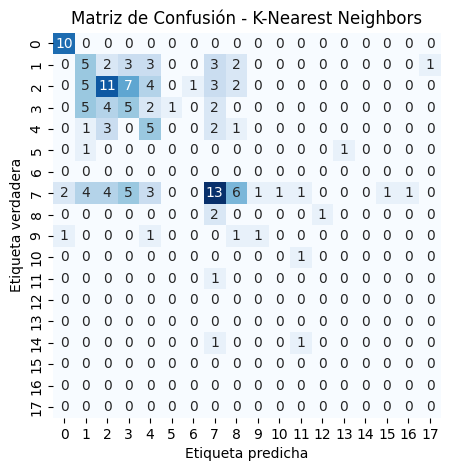

2024/10/19 11:54:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:54:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-grub-203 at: http://localhost:5000/#/experiments/21/runs/3137a386ad6e4f60a116a854f2796ddd.
2024/10/19 11:54:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/21.


Modelo registrado en MLflow para K-Nearest Neighbors
K-Nearest Neighbors Cross-Validation Accuracy: 0.8874445149017121



In [28]:
main(filepath=r'D:\Smartware\Google Drive\Documentos\Tec de Monterrey\MNA\OAA\Semana 5\data\Absenteeism_at_work.csv')

In [29]:
import mlflow
logged_model = 'runs:/48dab183113f498484e7262ff115880f/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
    data = DataHandler.load_data('D:\Smartware\Google Drive\Documentos\Tec de Monterrey\MNA\OAA\Semana 5\data\Absenteeism_at_work.csv')
    df_cleaned = DataHandler.prepared_data(data)
   
    # Definir las columnas numéricas y categóricas
    numeric_columns = ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target']
    categorical_columns = ['Month of absence', 'Day of the week', 'Seasons', 'Education', 'Disciplinary failure', 'Social drinker', 'Social smoker']

    # Preprocesamiento de los datos
    preprocessor = Preprocessor()
    df_preprocessed = preprocessor.preprocess_data(df_cleaned, numeric_columns, categorical_columns)


    # 4. Dividir los datos para entrenamiento y evaluación
    model_training = ModelTraining()
    X_train, X_test, y_train, y_test = model_training.split_data(df_preprocessed, 'Absenteeism time in hours')

    loaded_model.predict(X_test)

1.- Loading and exploring the data
2.- Prepared the data
               ID  Reason for absence  Month of absence  Day of the week  \
count  740.000000          740.000000        740.000000       740.000000   
mean    18.017568           19.216216          6.324324         3.914865   
std     11.021247            8.433406          3.436287         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%      9.000000           13.000000          3.000000         3.000000   
50%     18.000000           23.000000          6.000000         4.000000   
75%     28.000000           26.000000          9.000000         5.000000   
max     36.000000           28.000000         12.000000         6.000000   

          Seasons  Transportation expense  Distance from Residence to Work  \
count  740.000000              740.000000                       740.000000   
mean     2.544595              221.329730                        29.631081   
std      1.111831       

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\julio\AppData\Local\Temp\ipykernel_33824\3195671460.py:1: SyntaxWarning: invalid escape sequence '\S'
  data = DataHandler.load_data('D:\Smartware\Google Drive\Documentos\Tec de Monterrey\MNA\OAA\Semana 5\data\Absenteeism_at_work.csv')


array([2, 2, 8, 8, 3, 8, 2, 8, 8, 3, 0, 0, 8, 8, 0, 8, 1, 2, 8, 4, 8, 8,
       3, 0, 2, 8, 8, 3, 2, 8, 8, 8, 8, 2, 8, 3, 8, 8, 2, 8, 8, 8, 8, 2,
       2, 2, 8, 8, 8, 2, 2, 0, 8, 8, 2, 0, 1, 0, 8, 8, 8, 2, 3, 8, 8, 8,
       2, 1, 3, 8, 2, 8, 3, 8, 8, 8, 2, 3, 8, 8, 0, 2, 8, 8, 0, 0, 4, 8,
       8, 1, 1, 0, 8, 1, 8, 3, 3, 2, 8, 8, 8, 8, 8, 3, 3, 2, 8, 3, 0, 2,
       8, 8, 8, 4, 1, 1, 2, 1, 8, 8, 8, 8, 8, 2, 3, 8, 0, 2, 8, 8, 2, 2,
       2, 3, 2, 8, 8, 2, 8, 1, 1, 4, 8, 3, 3, 2, 4, 3], dtype=int64)